In [12]:
import pandas as pd

In [13]:
checkin = pd.read_csv('./MSC-Checkin.csv')
ages = pd.read_csv('../data/raw/participants.csv')

checkin.columns


Index(['Family ID', 'ContactName.first', 'ContactName.last', 'Email', 'Center',
       'City', 'Participants.name.first', 'Participants.name.last',
       'Participants.gender', 'Category', 'PAID', 'Decided',
       'Check-in Status'],
      dtype='object')

In [14]:
ages.columns

Index(['Family ID', 'ContactName.last', 'ContactName.first', 'Email', 'Center',
       'Address.city', 'Participants.name.last', 'Participants.name.first',
       'Participants.gender', 'Age Group', 'Grade/Age Category', 'PAID',
       'Decided'],
      dtype='object')

### Merge `participants.csv` and `MSC-Checkin.csv`

1. Clean trailing spaces
2. Add "Grade/Age Category" as "Category"
3. Save as `checkin_with_ages.csv`

In [15]:
# List of columns to clean (strip spaces and lowercase for merge)
merge_cols = [
    'Family ID',
    'Participants.name.first',
    'Participants.name.last',
    'Participants.gender'
]

def clean_merge_keys(df, cols):
    for col in cols:
        # Convert to string, strip spaces, and lowercase for robust matching
        df[col] = df[col].astype(str).str.strip().str.lower()
    return df

# Clean merge keys in both dataframes
checkin_clean = clean_merge_keys(checkin.copy(), merge_cols)
ages_clean = clean_merge_keys(ages.copy(), merge_cols)

# Merge using cleaned keys, but keep original columns for output
merged = pd.merge(
    checkin_clean,
    ages_clean[['Family ID', 'Participants.name.first', 'Participants.name.last', 'Participants.gender', 'Grade/Age Category']],
    on=merge_cols,
    how='left'
)

# Drop the old Category column if it exists, and use the new one
if 'Category' in merged.columns:
    merged = merged.drop(columns=['Category'])
merged = merged.rename(columns={'Grade/Age Category': 'Category'})

# Reorder columns: move 'Category' to just before 'PAID'
cols = list(merged.columns)
if 'Category' in cols and 'PAID' in cols:
    cols.remove('Category')
    paid_index = cols.index('PAID')
    cols = cols[:paid_index] + ['Category'] + cols[paid_index:]
    merged = merged[cols]

# Save the cleaned and merged DataFrame
merged.to_csv('checkin_with_ages.csv', index=False)
print("Merged file saved with cleaned merge keys and 'Category' filled wherever possible.")

Merged file saved with cleaned merge keys and 'Category' filled wherever possible.


In [16]:
# Count CHYK and JCHYK participants who have checked in
chyk_checkedin = merged[
    (merged['Category'].str.contains('CHYK', na=False, case=False)) & 
    (~merged['Category'].str.contains('JCHYK', na=False, case=False)) &
    (merged['Check-in Status'] == 'checked-in')
]['Category'].count()

jchyk_checkedin = merged[
    (merged['Category'].isin(['9', '10', '11', '12'])) & 
    (merged['Check-in Status'] == 'checked-in')
]['Category'].count()

print(f"Number of CHYK participants who have checked in: {chyk_checkedin}")
print(f"Number of JCHYK participants who have checked in: {jchyk_checkedin}")
print(f"Total number of CHYK and JCHYK participants who have checked in: {chyk_checkedin + jchyk_checkedin}")


Number of CHYK participants who have checked in: 98
Number of JCHYK participants who have checked in: 49
Total number of CHYK and JCHYK participants who have checked in: 147


### How many CHYKs have not checked in yet?

In [17]:
# Count CHYK participants who haven't checked in
chyk_not_checkedin = merged[
    (merged['Category'].str.contains('CHYK', na=False)) & 
    (merged['Check-in Status'].isna())
]['Category'].count()

print(f"Number of CHYK participants who haven't checked in: {chyk_not_checkedin}")


Number of CHYK participants who haven't checked in: 21


### Create complete CHYK/CSK list

In [18]:
# Filter for CHYK participants and 30-35 age group
chyk_and_30_35_df = merged[
    (merged['Category'].str.contains('CHYK', na=False)) |
    (merged['Category'] == '30 to 35 years old')
]

# Create full name column and select relevant columns 
chyk_and_30_35_output = pd.DataFrame({
    'Name': chyk_and_30_35_df['Participants.name.first'] + ' ' + chyk_and_30_35_df['Participants.name.last'],
    'Category': chyk_and_30_35_df['Category']
})

# Save to Excel
chyk_and_30_35_output.to_excel('chyk_participants.xlsx', index=False)

print("CHYK and 30-35 year old participants list saved to chyk_participants.xlsx")


CHYK and 30-35 year old participants list saved to chyk_participants.xlsx


### How many CHYKs in total?

In [19]:
# Count total number of CHYK participants
total_chyks = merged[merged['Category'].str.contains('CHYK', na=False)]['Category'].count()

print(f"Total number of CHYK participants: {total_chyks}")




Total number of CHYK participants: 119


### Age-based Analytics

/var/folders/s2/zqq2s_vs0nv0_017hnyd2jnr0000gn/T/ipykernel_51797/1105168502.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=city_counts.index, x=city_counts.values, palette="Blues_d")
/var/folders/s2/zqq2s_vs0nv0_017hnyd2jnr0000gn/T/ipykernel_51797/1105168502.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=checkin_counts.index, y=checkin_counts.values, palette="Set2")
/var/folders/s2/zqq2s_vs0nv0_017hnyd2jnr0000gn/T/ipykernel_51797/1105168502.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_c

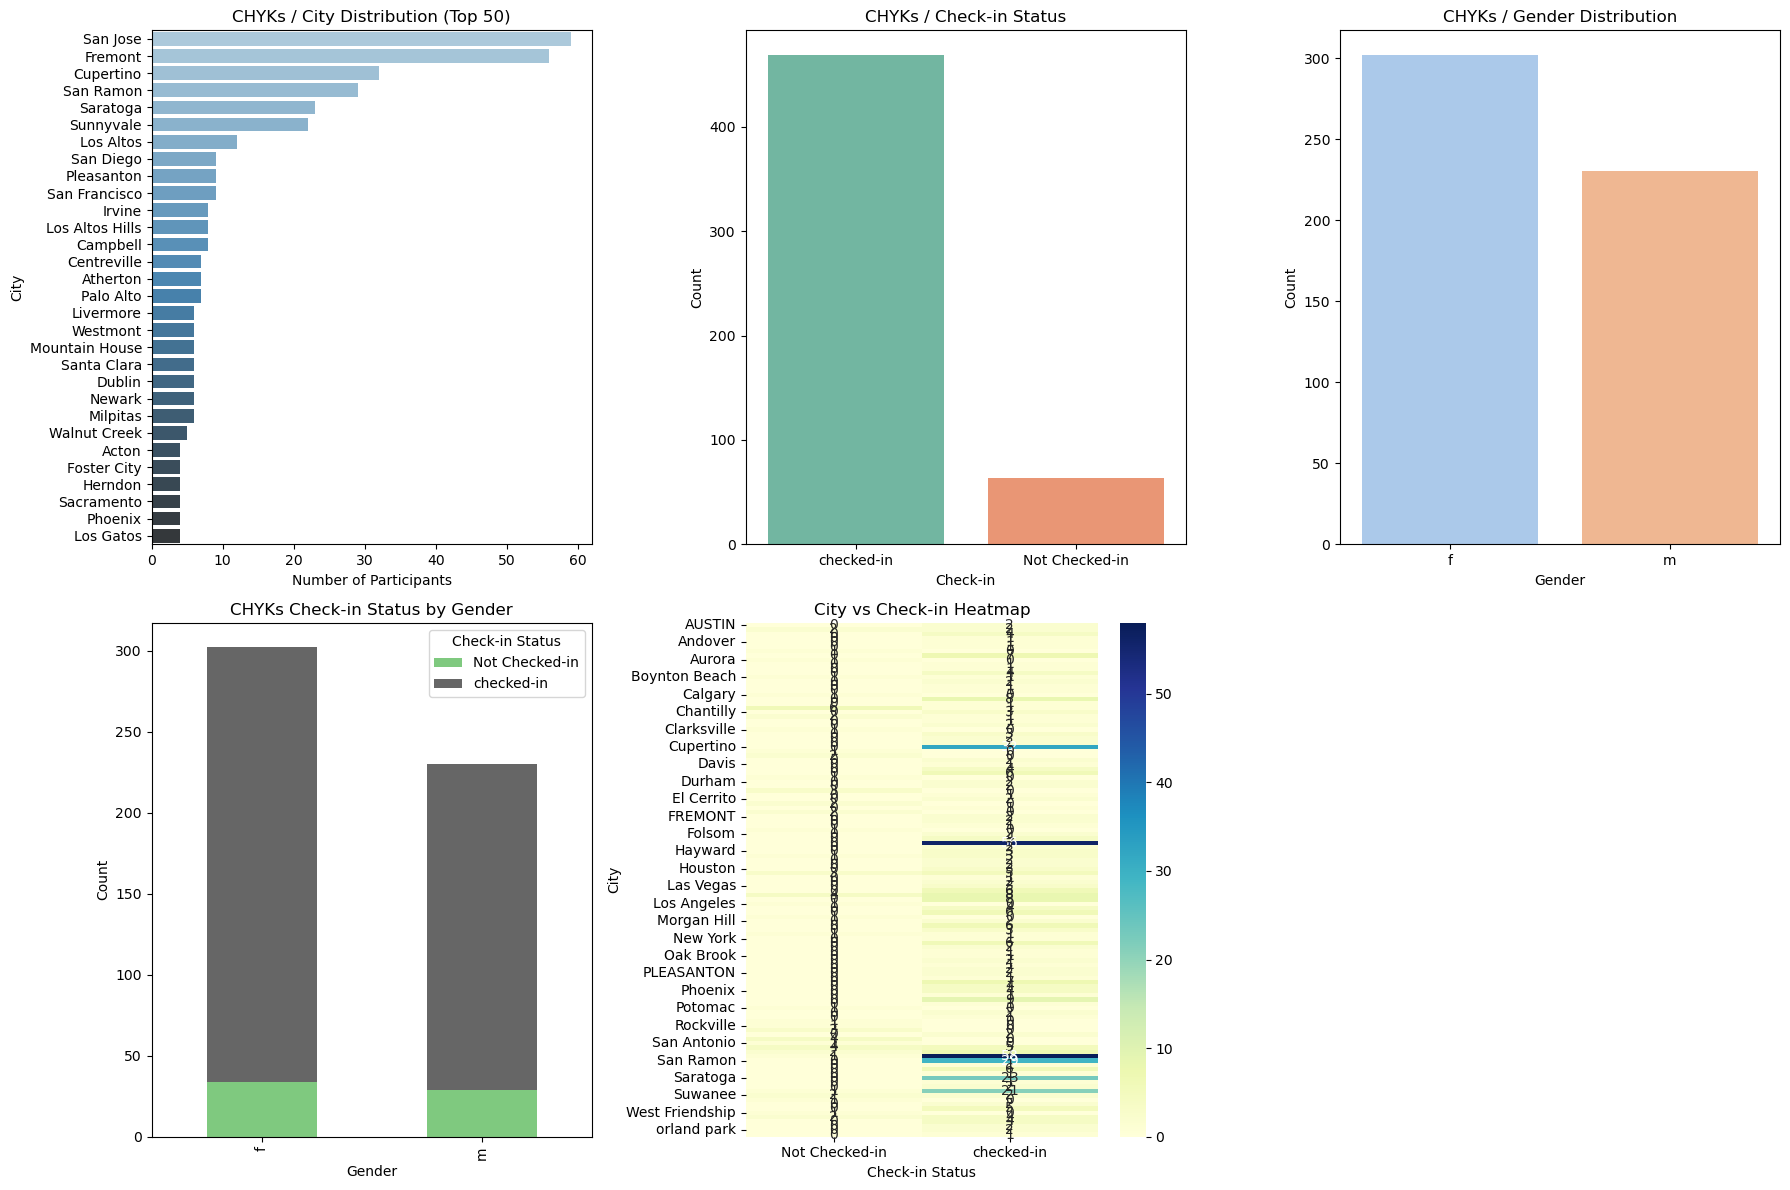

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = merged

# Filter to include only rows where 'Category' contains "CHYK" or "years old"
filtered_df = df[df['Category'].str.contains('CHYK|years old', na=False)]

# Start plotting
plt.figure(figsize=(18, 12))

# Plot 1: CHYKs / City Distribution
plt.subplot(2, 3, 1)
city_counts = filtered_df['City'].value_counts().sort_values(ascending=False).head(30)
sns.barplot(y=city_counts.index, x=city_counts.values, palette="Blues_d")
plt.title('CHYKs / City Distribution (Top 50)')
plt.xlabel('Number of Participants')
plt.ylabel('City')

# Plot 2: CHYKs / Check-in Status
plt.subplot(2, 3, 2)
checkin_counts = filtered_df['Check-in Status'].fillna('Not Checked-in').value_counts()
sns.barplot(x=checkin_counts.index, y=checkin_counts.values, palette="Set2")
plt.title('CHYKs / Check-in Status')
plt.xlabel('Check-in')
plt.ylabel('Count')

# Plot 3: CHYKs / Gender Distribution
plt.subplot(2, 3, 3)
gender_counts = filtered_df['Participants.gender'].value_counts()
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="pastel")
plt.title('CHYKs / Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# Plot 4: Check-in Status by Gender
plt.subplot(2, 3, 4)
checkin_gender = pd.crosstab(filtered_df['Participants.gender'], filtered_df['Check-in Status'].fillna('Not Checked-in'))
checkin_gender.plot(kind='bar', stacked=True, ax=plt.gca(), colormap="Accent")
plt.title('CHYKs Check-in Status by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Plot 5: City vs Check-in Count (Heatmap)
plt.subplot(2, 3, 5)
city_checkin = pd.crosstab(filtered_df['City'], filtered_df['Check-in Status'].fillna('Not Checked-in'))
sns.heatmap(city_checkin, annot=True, fmt='d', cmap='YlGnBu')
plt.title('City vs Check-in Heatmap')
plt.xlabel('Check-in Status')
plt.ylabel('City')

plt.tight_layout()
plt.show()


In [21]:
df.columns

Index(['Family ID', 'ContactName.first', 'ContactName.last', 'Email', 'Center',
       'City', 'Participants.name.first', 'Participants.name.last',
       'Participants.gender', 'Category', 'PAID', 'Decided',
       'Check-in Status'],
      dtype='object')

In [22]:
# Count unique cities
num_cities = df['City'].nunique()
print(f"Total number of unique cities: {num_cities}")

# Display list of cities
print("\nList of cities:")
print(df['City'].unique())


Total number of unique cities: 175

List of cities:
['Saratoga' 'San Ramon' 'Fremont' 'Los Altos' 'San Mateo' 'CUMMING'
 'North Brunswick' 'Westmont' 'Robbinsville Township' 'Westminster'
 'Libertyville' 'Orlando' 'Delray Beach' 'Johns Creek' 'Windermere'
 'Moorpark' 'Stamford' 'Concord' 'Plano' 'San Jose' 'Oak Brook' 'Andover'
 'Hinsdale' 'Acton' 'Herndon' 'Olathe' 'Centreville' 'Metairie'
 'Ann Arbor' 'Atherton' 'Ashburn' 'Cupertino' 'Wesley Chapel' 'Pleasanton'
 'Mountain House' 'Oakland' 'Palo Alto' 'Sunnyvale' 'Tracy' 'Campbell'
 'Dublin' 'Hollister' 'san jose' 'Los altos' 'Livermore' 'SAN JOSE'
 'Naperville' 'San Antonio' 'Newark' 'Morgan Hill' 'Chantilly'
 'Alpharetta' 'Berkeley' 'Mountain View' 'Los Altos Hills' 'Lincolnshire'
 'Walnut Creek' 'Anaheim' 'Thousand Oaks' 'San Diego' 'Sacramento'
 'Fairfax' 'San Francisco' 'Bakersfield' 'Granite Bay' 'Durham' 'Tustin'
 'EDWARDS' 'Longwood' 'Danville' 'College Station' 'Milpitas' 'Irvine'
 'Novato' 'Artesia' 'Chapel Hill' 'Novi' 'Ha